# Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Создаем синтетические данные

Задаем функции генерации данных

In [181]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise):
    return np.random.randn(*shape) *noise

def dataset(a, b, f = None,  N = 250, x_max =1, noise = 0, random_x = True,  seed = 123):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise)

    return y, y_true, np.atleast_2d(x).T

In [182]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Шум",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Настоящие данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()


Генерируем данные и шум

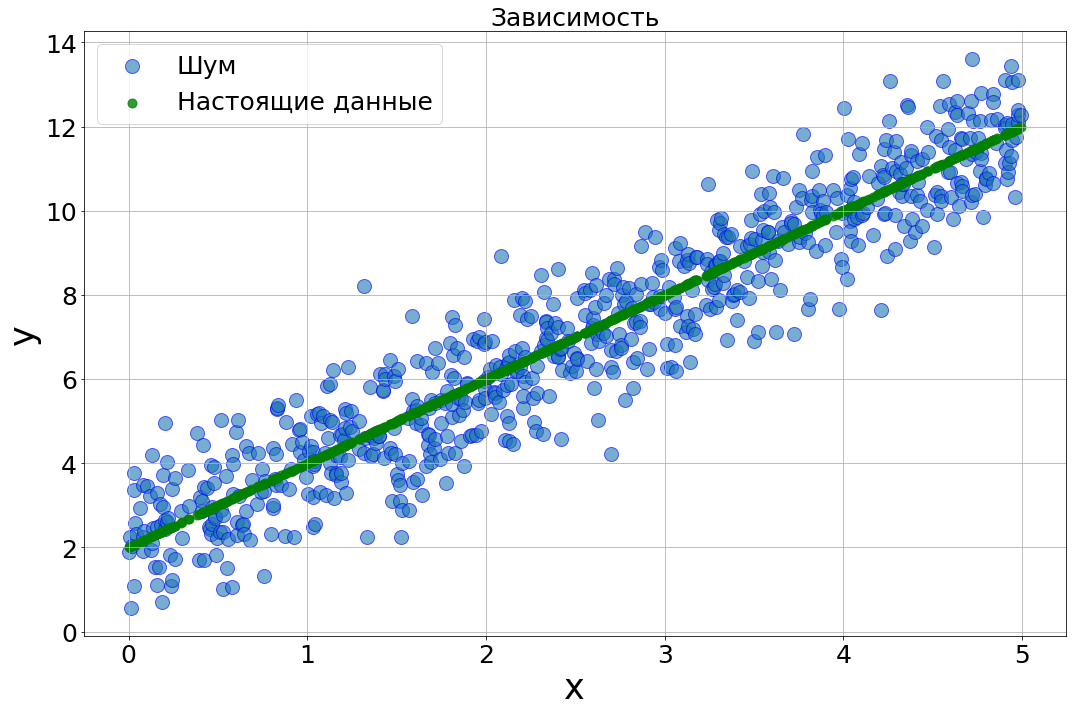

In [183]:
noise = 1

y, y_true, x = dataset(a = 2, b = 2,
                       f = None,  N = 700,
                       x_max = 5, 
                       noise = noise,
                       seed = 123)
vis_data(y, y_true,x, 'Зависимость')

Делим все на тренировочную и тестовую выборки

In [184]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=50, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(350, 1) (350,) (140, 1) (140,) (210, 1) (210,)
(489, 1) (489,) (211, 1) (211,)


In [185]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(489, 1) (489,) (211, 1) (211,)


Класс для регрессии

In [186]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Производим линейную регрессию

In [187]:
myreg = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
myreg.fit(x_train, y_train)

Функция потерь

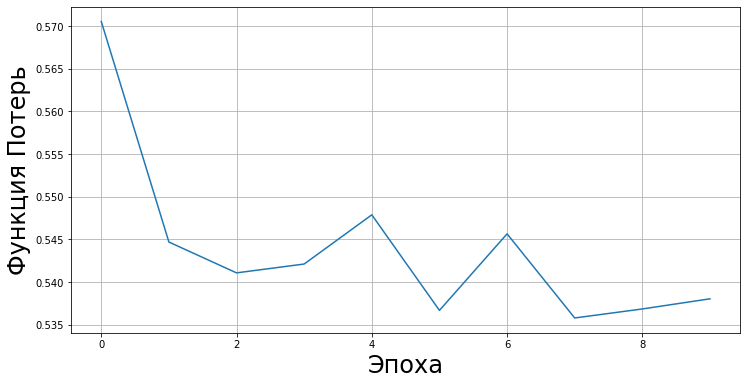

In [176]:
myreg.plot_cost()

In [188]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Прогноз на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Прогноз на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Настоящие данные", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

Смотрим график

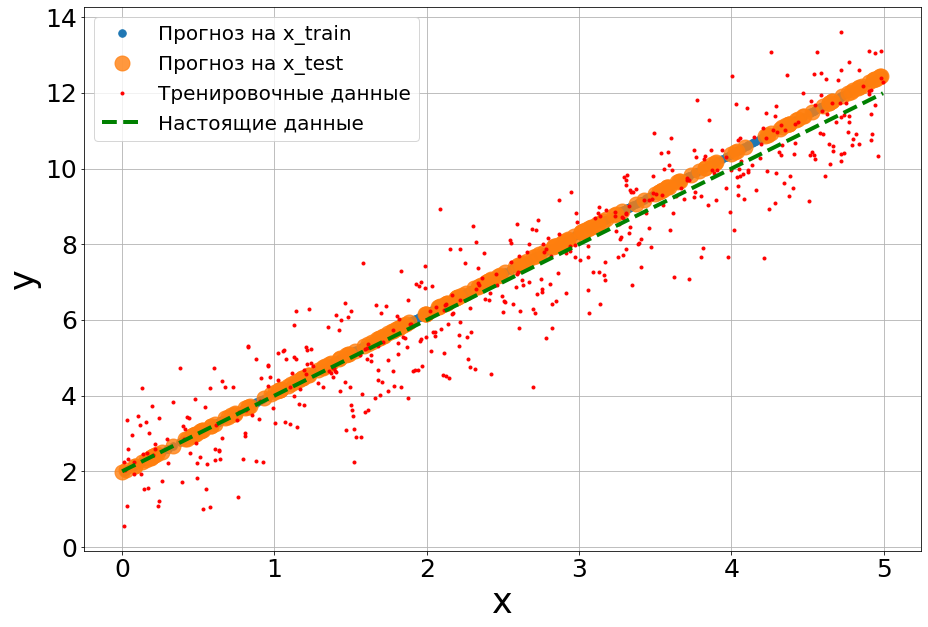

In [189]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, myreg)

**Вывод**

Тут мы видим, что на данных с большим шумом значения потерь уменьшаются медленнее и нестабильнее чем на данных с маленьким шумом, но, так или иначе, наша модель приходит к точным предсказаниям.

# Полиномиальная зависимость

Меняем данные, добавляем шум и уменьшаем максимальный Х

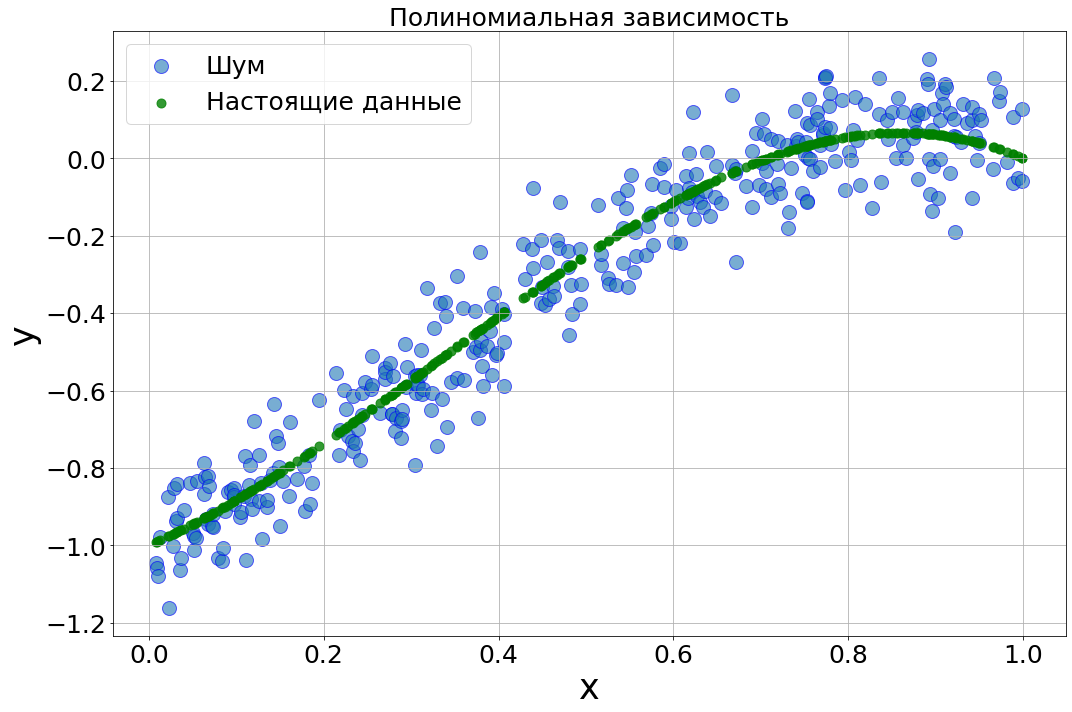

In [190]:
noise = 0.09

y, y_true, x = dataset(a = [1,2,-2], b = -1,
                       f = None,  N = 350,
                       x_max =1, 
                       noise = noise,
                       seed = 130)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

Создаём полином в 6й степени

In [191]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T
  

In [192]:
x_ = to_polynom(x, order = 6) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

Проводим линейную регрессию

In [193]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [194]:
regr_poly.fit(x_train, y_train)

Смотрим график

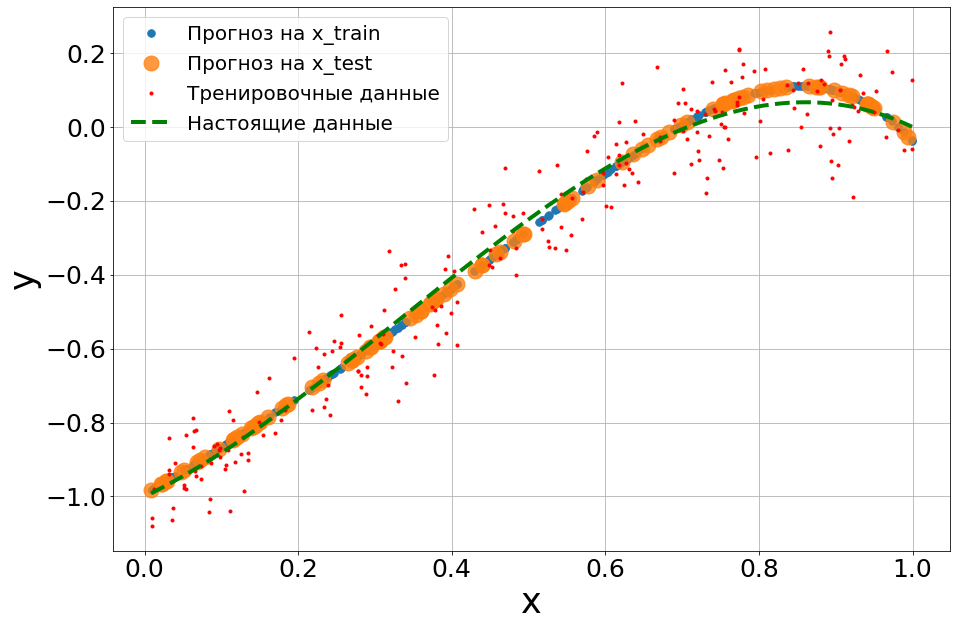

In [195]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)


Посмотрим, поможет ли увеличение размера выборки в более точном предсказании гармонических данных

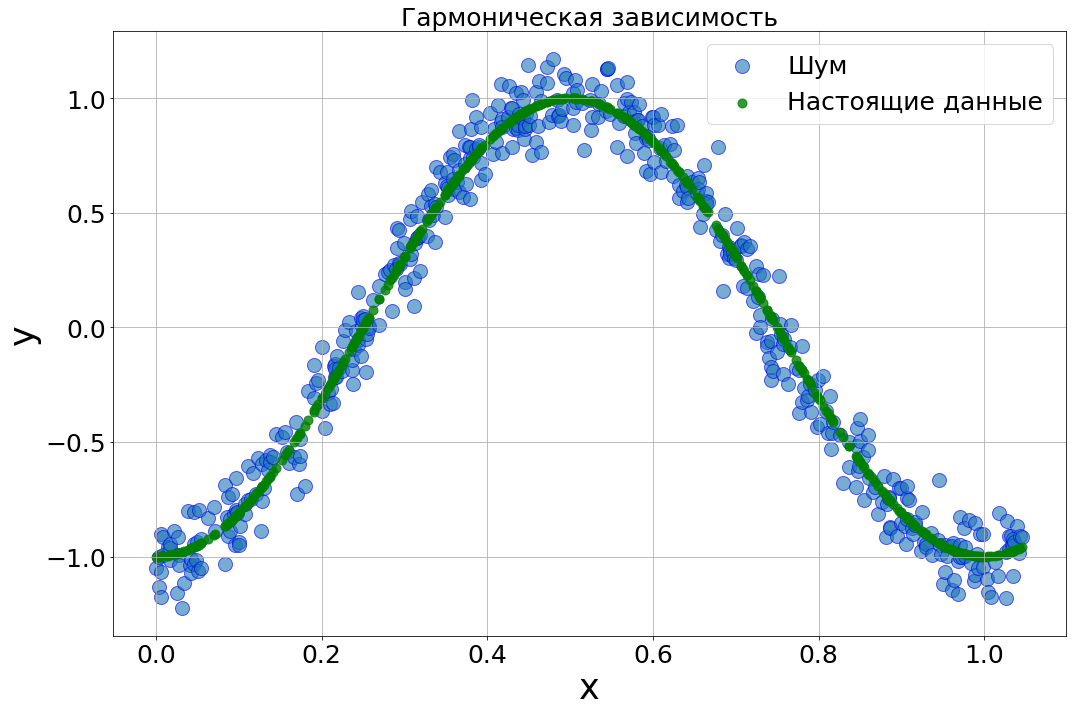

In [196]:
y, y_true, x = dataset(a = 2*np.pi,
                       b = np.pi, f = np.cos,  
                       N = 500, x_max =np.pi/3, 
                       noise = 0.1, seed = 123)
vis_data(y, y_true,x, 'Гармоническая зависимость')

In [197]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(350, 1) (350,) (150, 1) (150,)


Train Score = -0.13


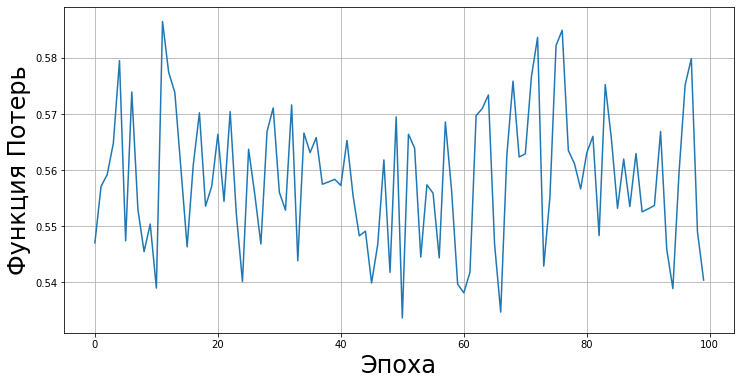

In [198]:
regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

In [199]:
w, b = regr_harm.get_w_and_b()
print(w,b)

[-0.16635996] 0.3519484863212222


Создаём полиномв в 12й степени

In [200]:
order  = 12

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9,10,11
346,0.639862,0.409424,0.261975,0.167628,0.107259,0.068631,4.391428e-02,2.809909e-02,1.797955e-02,1.150444e-02,7.361256e-03,4.710190e-03
347,0.179156,0.032097,0.005750,0.001030,0.000185,0.000033,5.924170e-06,1.061353e-06,1.901483e-07,3.406631e-08,6.103199e-09,1.093428e-09
348,0.121075,0.014659,0.001775,0.000215,0.000026,0.000003,3.814072e-07,4.617899e-08,5.591135e-09,6.769484e-10,8.196173e-11,9.923541e-12
349,0.132950,0.017676,0.002350,0.000312,0.000042,0.000006,7.342122e-07,9.761361e-08,1.297774e-08,1.725393e-09,2.293912e-10,3.049759e-11


Проводим линейную регрессию

Test Score = 0.94, Train Score = 0.93


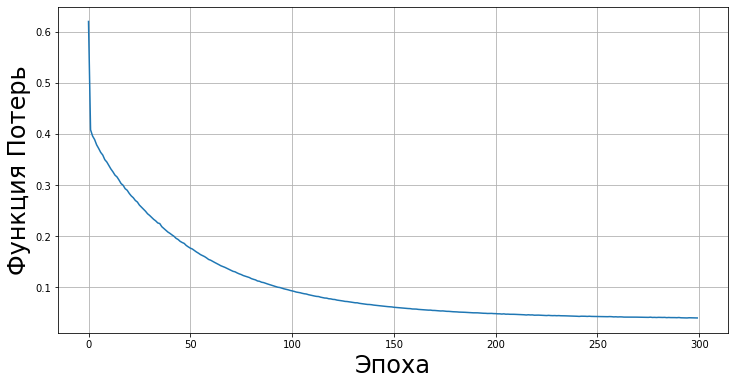

In [201]:
regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

In [202]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 4.8431447  -0.19519958 -2.01940084 -2.08867251 -2.19482211 -1.55807658
 -0.37061295  0.00604072  0.18266135  0.93018734  1.0246773   1.34875851] -1.0984718468881591


Создаем скейлеры

In [203]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [204]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [205]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

In [206]:
pd.DataFrame(x_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8,9,10,11
146,-0.909616,-0.910769,-0.808602,-0.710634,-0.633498,-0.574186,-0.527722,-0.490333,-0.459493,-0.433525,-0.411293,-0.391999
147,1.012276,0.967616,0.833816,0.674624,0.516676,0.372053,0.245590,0.138306,0.049276,-0.023324,-0.081637,-0.127818
148,1.652247,2.043131,2.313072,2.510495,2.655466,2.759835,2.831942,2.878026,2.902884,2.910293,2.903294,2.884382
149,-0.499650,-0.680223,-0.701470,-0.665300,-0.615336,-0.567159,-0.525065,-0.489345,-0.459129,-0.433393,-0.411245,-0.391982


Больше линейных регрессий

Test Score = 0.96, Train Score = 0.96


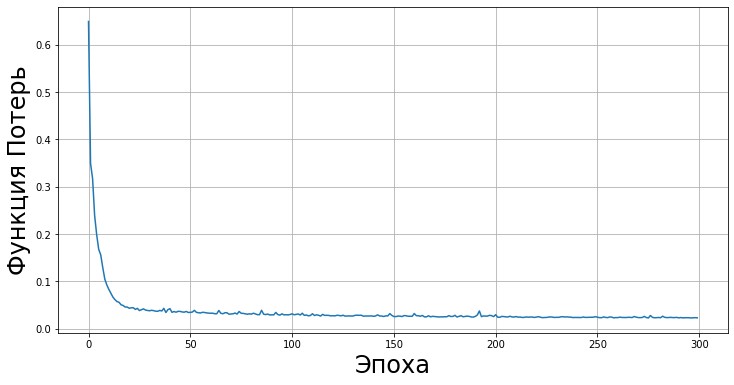

In [207]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Смотрим веса

In [208]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.98073711 -0.45767217 -1.22540389 -0.87533762 -0.86202569 -0.31263115
  0.62050344  0.60933357  0.29749219  0.48619061 -0.02259164 -0.3252497 ] -0.014110945990248334


In [209]:
np.sum(np.abs(w))

8.075168788056859

Смотрим график

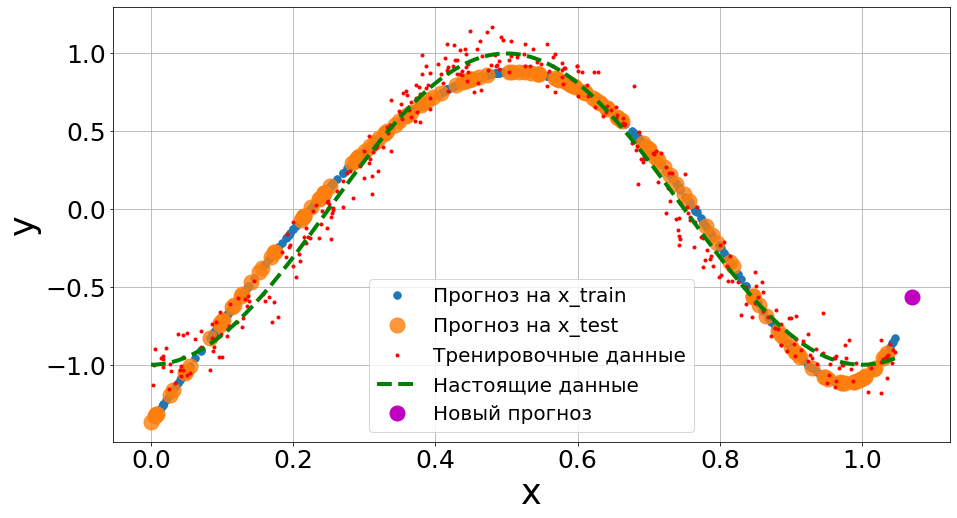

In [210]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Прогноз на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Прогноз на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Настоящие данные", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'Новый прогноз',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);



**Вывод**

Как мы видим, ситуация не особо улучшилась

Тогда попробуем увеличить разрядность полинома, и повторим наш эксперимент

In [211]:
order  = 17

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
346,0.639862,0.409424,0.261975,0.167628,0.107259,0.068631,4.391428e-02,2.809909e-02,1.797955e-02,1.150444e-02,7.361256e-03,4.710190e-03,3.013873e-03,1.928464e-03,1.233951e-03,7.895591e-04,5.052091e-04
347,0.179156,0.032097,0.005750,0.001030,0.000185,0.000033,5.924170e-06,1.061353e-06,1.901483e-07,3.406631e-08,6.103199e-09,1.093428e-09,1.958946e-10,3.509579e-11,6.287638e-12,1.126471e-12,2.018146e-13
348,0.121075,0.014659,0.001775,0.000215,0.000026,0.000003,3.814072e-07,4.617899e-08,5.591135e-09,6.769484e-10,8.196173e-11,9.923541e-12,1.201496e-12,1.454714e-13,1.761300e-14,2.132499e-15,2.581930e-16
349,0.132950,0.017676,0.002350,0.000312,0.000042,0.000006,7.342122e-07,9.761361e-08,1.297774e-08,1.725393e-09,2.293912e-10,3.049759e-11,4.054659e-12,5.390675e-13,7.166910e-14,9.528417e-15,1.266804e-15


In [212]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

Test Score = 0.97, Train Score = 0.97


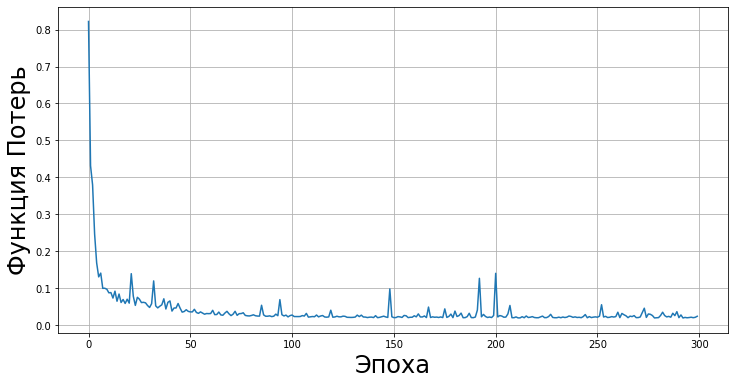

In [213]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Смотрим веса

In [214]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.90470407 -0.23628114 -1.12349201 -0.98384569 -1.02666093 -0.53977724
  0.32787662  0.44426812  0.33795383  0.67284955  0.43533718  0.37912927
  0.45102919 -0.20091466 -0.30255429 -0.17740641 -0.44668816] -0.010837238131813401


In [215]:
np.sum(np.abs(w))

9.990768342678564

Смотрим график

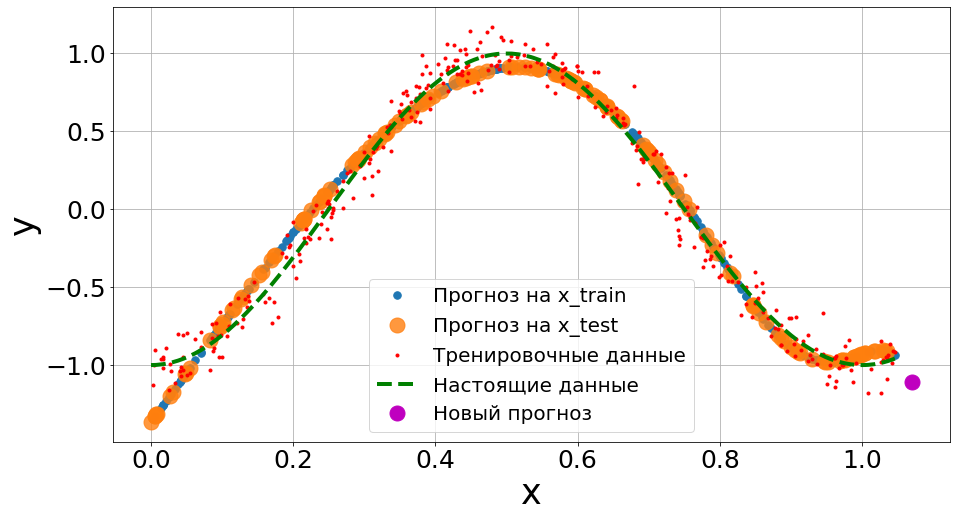

In [218]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Прогноз на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Прогноз на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Настоящие данные", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'Новый прогноз',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);



# Реальные данные (Cars Moldova)

Импортируем необходимые библиотеки и таблицу, полученную в прошлой работе

In [219]:
from google.colab import files
import seaborn as sns; 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [41]:
uploaded = files.upload()

Saving cars_moldova_norm (1).csv to cars_moldova_norm (1).csv


In [220]:
df = pd.read_csv('/content/cars_moldova_norm.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,mileage
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,medium
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,medium
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,medium
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,medium
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667,medium
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000,medium
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714,medium
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000,medium


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32220 non-null  object 
 1   Model                 32220 non-null  object 
 2   Year                  32220 non-null  int64  
 3   Style                 32220 non-null  object 
 4   Distance              32220 non-null  float64
 5   Engine_capacity(cm3)  32220 non-null  float64
 6   Fuel_type             32220 non-null  object 
 7   Transmission          32220 non-null  object 
 8   Price(euro)           32220 non-null  float64
 9   Age                   32220 non-null  int64  
 10  km_year               32220 non-null  float64
 11  mileage               32220 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 2.9+ MB


In [222]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'mileage']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

Делаем линейную регрессию по числовым столбцам

Сначала разделим данные на тренировочный и тестовый датасеты

In [224]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=140)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


,0,1,2,3
22549,0.54,0.299930,0.479167,0.248497
22550,0.60,0.122912,0.166667,0.115374
22551,0.90,0.049905,0.364583,0.164997
22552,0.72,0.223922,0.250000,0.297261
22553,0.92,0.140914,0.373958,0.563126


Добавим класс линейной регрессии

In [225]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15, mfc='none' ); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);

In [227]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 200, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 140):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Запускаем линейную регрессию

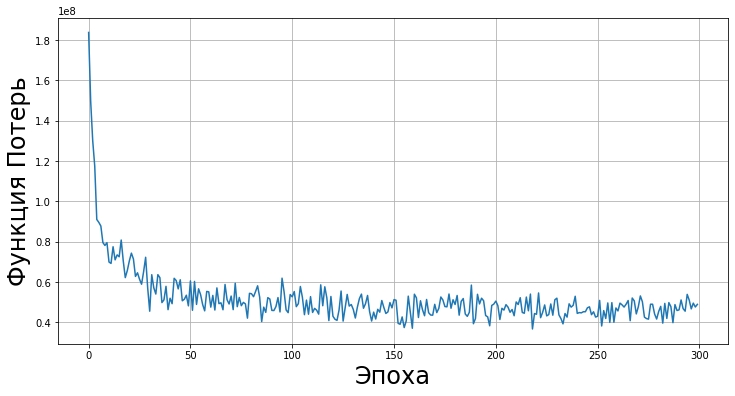

train R2: 0.4854; test R2: 0.4768


In [228]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Смотрим веса

In [229]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 );

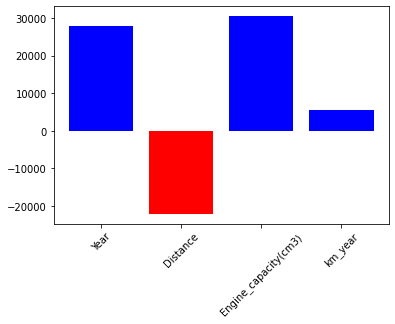

In [230]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [231]:
np.sum(np.abs(w))

85836.76061093569

Регуляризация

In [235]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 200, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 140):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term) 


Запускаем регрессию с регуляризацией

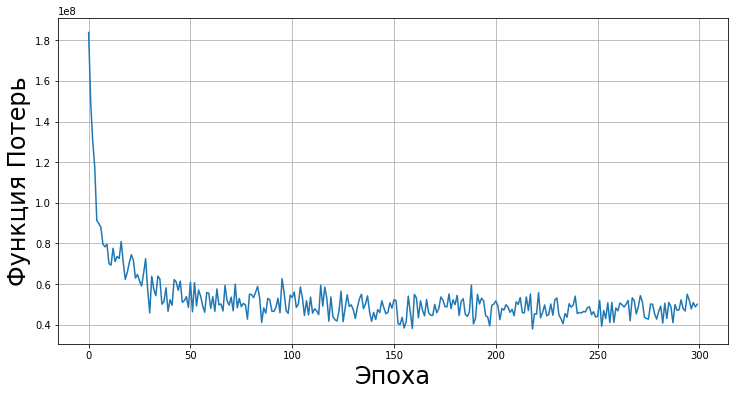

train R2: 0.4850; test R2: 0.4766


In [236]:
regr = RidgeRegression(learning_rate=0.5,epochs=300,batch_size=3000, l2_penalty = 0.001)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Опять веса

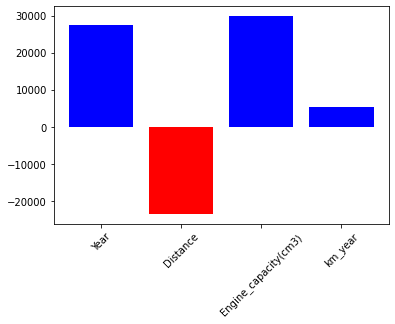

In [237]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [238]:
np.sum(np.abs(w))

86120.69034742688

Как мы можем наблюдать, ничего не изменилось

# Различные типы предварительной обработки

Нормализуем данные

In [239]:
DF_norm  = df_num.copy()
Xmin = df_num[num_columns].min()
Xmax = df_num[num_columns].max()

DF_norm[num_columns] = (df_num[num_columns]- Xmin)/( Xmax - Xmin)
DF_norm.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0.80,0.194919,0.333333,0.075651,0.353252
1,0.86,0.134913,0.270833,0.083667,0.336172
2,0.82,0.109911,0.270833,0.063627,0.218437
3,0.70,0.199920,0.291667,0.039078,0.248497
4,0.58,0.299930,0.416667,0.032966,0.271270


Делим на тестовую и тренировочную выборку

In [241]:
X,y = DF_norm.drop(columns = ['Price(euro)']).values,DF_norm['Price(euro)'].values

features_names = DF_norm.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3
22549,0.40,0.011012,0.291667,0.005179
22550,0.74,0.208921,0.270833,0.297166
22551,0.84,0.155127,0.270833,0.343601
22552,0.84,0.219922,0.229167,0.487865
22553,0.94,0.049905,0.375000,0.248497


Снова линейная регрессия

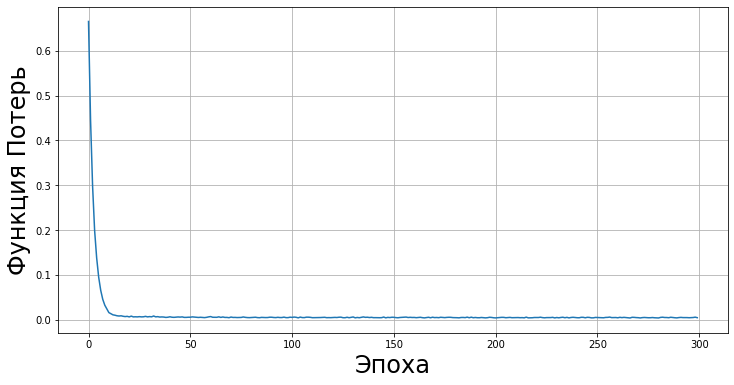

train R2: 0.4811; test R2: 0.4691


In [242]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Веса

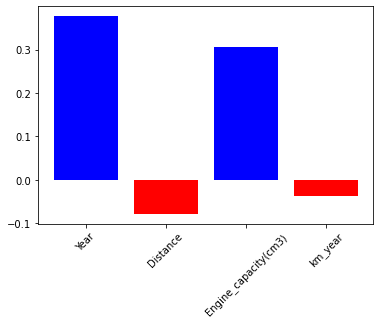

In [243]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [244]:
np.sum(np.abs(w))

0.7980972112517167

Нормализация данных помогла нам улучшить результаты. Уменьшения потерь стали плавнее, потери и веса уменьшились

Стандатизируем данные

In [245]:
DF_scaled = df_num.copy()
M = df_num[num_columns].mean()
STD = df_num[num_columns].std()
DF_scaled[num_columns] = (df_num[num_columns]-M)/STD

DF_scaled.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0.376492,0.128983,-0.112516,-0.179081,0.377953
1,0.793761,-0.490816,-0.604496,-0.095044,0.261792
2,0.515582,-0.749065,-0.604496,-0.305136,-0.538943
3,-0.318957,0.180633,-0.440503,-0.562500,-0.334500
4,-1.153495,1.213632,0.543457,-0.626578,-0.179619


Тренировочная и тестовая выборки

In [246]:
X,y = DF_scaled.drop(columns = ['Price(euro)']).values,DF_scaled['Price(euro)'].values

features_names = DF_scaled.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3
22549,0.40,0.011012,0.291667,0.005179
22550,0.74,0.208921,0.270833,0.297166
22551,0.84,0.155127,0.270833,0.343601
22552,0.84,0.219922,0.229167,0.487865
22553,0.94,0.049905,0.375000,0.248497


Регрессия

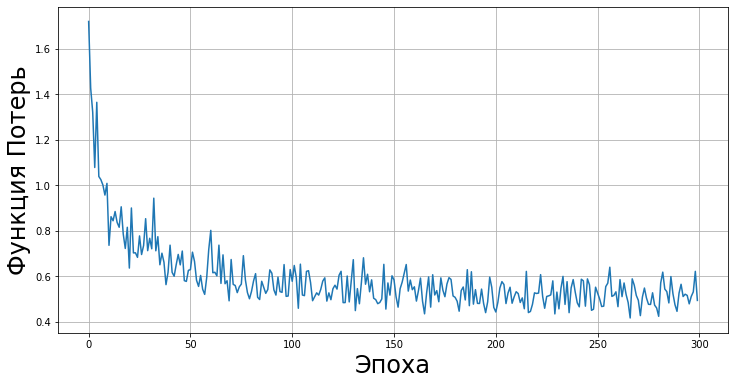

train R2: 0.4880; test R2: 0.4782


In [247]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Веса

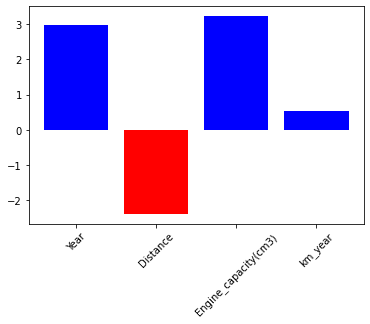

In [248]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [249]:
np.sum(np.abs(w))

9.123932411646747

В данном случае мы вернулись к ломанному графику функции потерь, но мы смогли уменьшить веса

# Добавляем категориальные признаки

One-hot кодирование

In [250]:
df_dum = df.copy()
df_dum = pd.get_dummies(df_dum[cat_columns])
df_dum

,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Dodge,...,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Automatic,Transmission_Manual,mileage_big,mileage_medium,mileage_small
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0
32216,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
32217,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
32218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


Добавляем нормализованные числовые признаки

In [251]:
df_dum['Year'] = DF_norm['Year']
df_dum['Distance'] = DF_norm['Distance']
df_dum['Engine_capacity(cm3)'] = DF_norm['Engine_capacity(cm3)']
df_dum['Price(euro)'] = DF_norm['Price(euro)']
df_dum['km_year'] = DF_norm['km_year']
df_dum

,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,Make_Dacia,Make_Daewoo,Make_Daihatsu,Make_Dodge,...,Transmission_Automatic,Transmission_Manual,mileage_big,mileage_medium,mileage_small,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.80,0.194919,0.333333,0.075651,0.353252
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.86,0.134913,0.270833,0.083667,0.336172
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.82,0.109911,0.270833,0.063627,0.218437
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.70,0.199920,0.291667,0.039078,0.248497
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.58,0.299930,0.416667,0.032966,0.271270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0.90,0.087909,0.333333,0.113226,0.291917
32216,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.62,0.224922,0.333333,0.042084,0.223447
32217,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0.88,0.088909,0.270833,0.068136,0.252791
32218,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0.70,0.369937,0.375000,0.038076,0.461423


In [252]:
X,y = df_dum.drop(columns = ['Price(euro)']).values,df_dum['Price(euro)'].values

features_names = df_dum.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
22549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.40,0.011012,0.291667,0.005179
22550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.74,0.208921,0.270833,0.297166
22551,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.84,0.155127,0.270833,0.343601
22552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.84,0.219922,0.229167,0.487865
22553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.94,0.049905,0.375000,0.248497


Уменьшим количество эпох и скорость обучения для достижения более качественных результатов

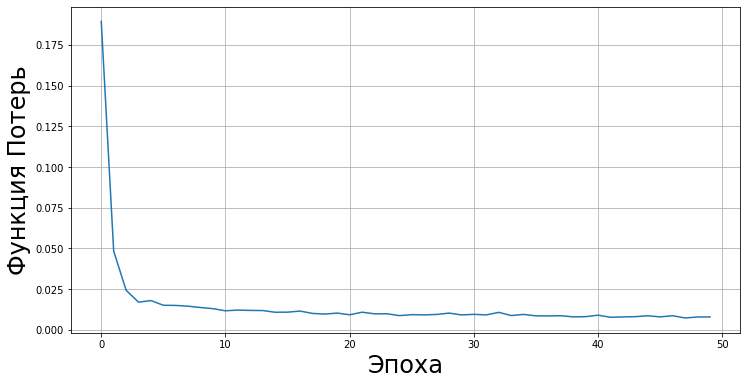

train R2: 0.1449; test R2: 0.1310


In [253]:
regr = LinearRegression(learning_rate=0.2,epochs=50,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

По получившемуся графику можно предположить, что точность прогнозирования улучшилась. Ведь значения функции уменьшились

# Анализируем веса

Взглянем на график весов модели с нормализированными данными. Похоже, по показателям функции потерь, самой точной из моделей.

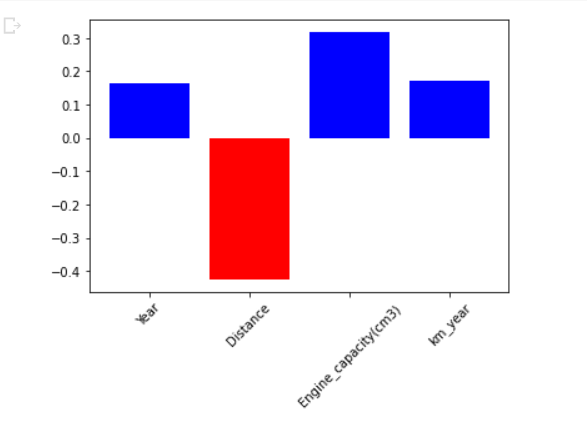

Кроме того мы можем наблюдать, что параметр Distance имеет отрицательный вес. Отсюда можно сделать логичный вывод, что цена увеличивается при уменьшении пробега (как мы и можем наблюдать на нашем рынке авто)

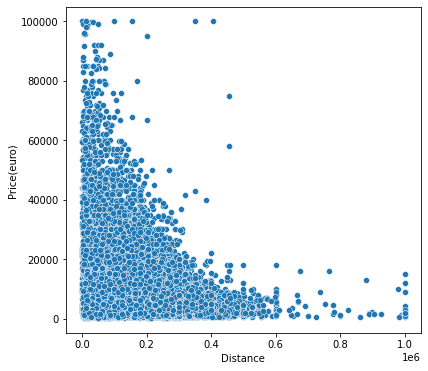

In [254]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='Distance',y='Price(euro)',data=df,ax=ax)

Также мы видим подтверждение, что объем двигателя имеет наибольшее значение в стоимости автомобиля. А год производства и удельный пробег влияют плюс-минус одинаково